# Part 3.2.3
## Notes
- number of inputs is constant at 2+1
- number of outputs is constant at 1
- beta = 1 
- been run 3 times for 2, 3 and 4 hidden nodes respectively

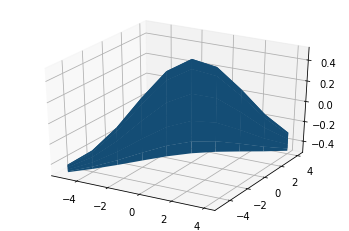

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = np.reshape(np.arange(-5, 5, 1, dtype=float), (-1,1))
y = np.reshape(np.arange(-5, 5, 1, dtype=float), (-1,1))
z = []

z = np.exp(-x*x*0.1) * np.exp(-y*y*0.1).T - 0.5

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x,y,z)
plt.show()

# setup targes and inputs. Each input col has r[0] = x, r[1] = y
# these corres. to targets 
targets = np.reshape(z, (1,len(x)**2))
[xx, yy] = np.meshgrid(x,y)
patterns = np.append( np.reshape(xx, (1,len(x)**2)), np.reshape(yy, (1,len(x)**2)), axis=0 ) 

In [11]:
class MLP:
    num_input = 2 + 1
    num_output = 1
    beta = 1

    def __init__(self, inputs, targets, num_hid_nodes, epochs, learning_rate):
        # input data
            # includes bias
        self.inputs_with_bias = self.setup_input_data(inputs)
        self.training_input = self.inputs_with_bias[0:self.num_input, 0:35].T
        self.testing_input = self.inputs_with_bias[0:self.num_input, 35:70].T
        self.validation_input = self.inputs_with_bias[0:self.num_input, 70:100].T

        # output data
        self.training_targets = np.reshape(targets[0:self.num_output, 0:35], (-1,1))
        self.testing_targets = np.reshape(targets[0:self.num_output, 35:70], (-1,1))
        self.validation_targets = np.reshape(targets[0:self.num_output, 70:100], (-1,1))

        # percepron(s) parameters
        self.num_hid_nodes = num_hid_nodes  
        self.epochs = epochs
        self.learning_rate = learning_rate

        # training parameters
        self.hidden_weights = np.ones((self.num_input, num_hid_nodes))*0.1
        self.output_weights = np.ones((self.num_hid_nodes+1, 1))*0.2

    def setup_input_data(self, inputs):
        inputs_with_bias = np.ones((np.shape(inputs)[0]+1,np.shape(inputs)[1]))*-1
        inputs_with_bias[:-1,:] = inputs
        return inputs_with_bias

    def fwd_pass(self, input_data):
        # activations from node1 in column 1,node2 in column 2... 
        hidden_layer_output = np.dot(input_data, self.hidden_weights)
        self.activations = 1/(1+np.exp(-self.beta*hidden_layer_output))

        # include bias
        self.activations = self.setup_input_data(self.activations.T)
        self.activations = self.activations.T
        # output of MLP in vector 
        output_layer_output = np.dot(self.activations, self.output_weights)
        self.output = 1/(1+np.exp(-self.beta*output_layer_output))        
    
    def bck_pass(self,target_data):
        # output error
        self.output_error = (self.output - target_data)*self.output*(1-self.output)
        # hidden layer error
        # loop through each error term
        self.hidden_layer_error = np.zeros((len(self.output_error),self.num_hid_nodes+1))
        for i in range(0, len(self.output_error)):
            # error vector for w_hidden_1, w_hidden_2, .... w_hidden_bias
            error = np.reshape(mlp.activations[i]*(1-mlp.activations[i]), (-1,1)) * (mlp.output_weights*mlp.output_error[i])
            error = np.reshape(error, (1,-1))
            # error for weight 1 in column 1, weight 2 in column 2 ... bias in last column
            self.hidden_layer_error[i] = error

    def average_errors(self, inputs):
        self.avg_output_error = np.reshape((np.sum(self.output_error))/np.shape(self.output_error)[0], (-1, 1))
        self.avg_hidden_error = np.reshape(np.sum(self.hidden_layer_error, 0)/np.shape(self.hidden_layer_error)[0], (-1, 1))
        self.avg_activations = np.reshape(np.sum(self.activations, 0)/np.shape(self.activations)[0], (-1, 1))
        self.avg_input_data = np.reshape(np.sum(inputs, 0)/np.shape(inputs)[0], (-1, 1))
    
    def update_weights(self):
        self.output_weights -= self.learning_rate*self.avg_output_error*self.avg_activations
        self.hidden_weights -= self.learning_rate*self.avg_hidden_error*self.avg_input_data

    def training(self):
        for e in range(0, epochs):
            self.fwd_pass(self.training_input)
            self.bck_pass(self.training_targets)
            self.average_errors(self.training_input)
            self.update_weights()
            print("Epoch: ", e, " has output error ", self.avg_output_error[0][0])

In [12]:
num_hid_nodes = 2
epochs = 20
learning_rate = 0.1

mlp_2_hidden_nodes = MLP(patterns, targets, num_hid_nodes, epochs, learning_rate)

mlp.training()


Epoch:  0  has output error  0.022561459078436635
Epoch:  1  has output error  0.022090761142457487
Epoch:  2  has output error  0.02163885986094321
Epoch:  3  has output error  0.021204691676412205
Epoch:  4  has output error  0.0207872684330829
Epoch:  5  has output error  0.020385671134321694
Epoch:  6  has output error  0.019999044273586397
Epoch:  7  has output error  0.01962659068315432
Epoch:  8  has output error  0.01926756685028361
Epoch:  9  has output error  0.018921278655376163
Epoch:  10  has output error  0.018587077491200817
Epoch:  11  has output error  0.01826435672631594
Epoch:  12  has output error  0.017952548479525075
Epoch:  13  has output error  0.017651120675535016
Epoch:  14  has output error  0.01735957435499122
Epoch:  15  has output error  0.017077441214768452
Epoch:  16  has output error  0.016804281356823013
Epoch:  17  has output error  0.01653968122609181
Epoch:  18  has output error  0.016283251719877906
Epoch:  19  has output error  0.01603462645291422

In [13]:
num_hid_nodes = 3
epochs = 20
learning_rate = 0.1

mlp_3_hidden_nodes = MLP(patterns, targets, num_hid_nodes, epochs, learning_rate)

mlp.training()

Epoch:  0  has output error  0.015793460163866926
Epoch:  1  has output error  0.015559427250447217
Epoch:  2  has output error  0.015332220421561007
Epoch:  3  has output error  0.01511154945605647
Epoch:  4  has output error  0.014897140058642492
Epoch:  5  has output error  0.014688732804460267
Epoch:  6  has output error  0.014486082164605674
Epoch:  7  has output error  0.014288955605632274
Epoch:  8  has output error  0.014097132756722518
Epoch:  9  has output error  0.013910404638805841
Epoch:  10  has output error  0.013728572950433846
Epoch:  11  has output error  0.013551449405701327
Epoch:  12  has output error  0.013378855119932642
Epoch:  13  has output error  0.013210620039241243
Epoch:  14  has output error  0.013046582410420348
Epoch:  15  has output error  0.01288658828793877
Epoch:  16  has output error  0.012730491075101354
Epoch:  17  has output error  0.012578151096691602
Epoch:  18  has output error  0.012429435200647213
Epoch:  19  has output error  0.01228421638

In [14]:
num_hid_nodes = 4
epochs = 20
learning_rate = 0.1

mlp_4_hidden_nodes = MLP(patterns, targets, num_hid_nodes, epochs, learning_rate)

mlp.training()

Epoch:  0  has output error  0.012142373458749939
Epoch:  1  has output error  0.012003790702651954
Epoch:  2  has output error  0.011868357581781232
Epoch:  3  has output error  0.01173596845472374
Epoch:  4  has output error  0.011606522310098413
Epoch:  5  has output error  0.01147992251837074
Epoch:  6  has output error  0.011356076599272381
Epoch:  7  has output error  0.01123489600370839
Epoch:  8  has output error  0.01111629590912323
Epoch:  9  has output error  0.011000195027378154
Epoch:  10  has output error  0.010886515424267029
Epoch:  11  has output error  0.010775182349865764
Epoch:  12  has output error  0.01066612407897263
Epoch:  13  has output error  0.010559271760953686
Epoch:  14  has output error  0.010454559278359768
Epoch:  15  has output error  0.01035192311372908
Epoch:  16  has output error  0.010251302224033405
Epoch:  17  has output error  0.01015263792226599
Epoch:  18  has output error  0.010055873765706222
Epoch:  19  has output error  0.0099609554504300